# Testing NASH for textile defects classification

The Neural Architecture Search by Hill Climbing algorithm is tested on the a dataset of images of fabric in order to classify textile orientation. This classification problem has 48000 images with 6 defect classes (i.e. 8000 images per label) for training and as many for testing

The algorithme is described in: [*Thomas Elsken, Jan-Hendrik Metzen, Frank Hutter, **Simple And Efficient rchitecture Search for Convolutional Neural Networks**, arXiV:1711.04528*](https://arxiv.org/abs/1711.04528).

The **nni.networkmorphism_tuner** library from the Microsoft NNI package is used to represent a neural network as a graph and apply function-preserving morphisms.

The dataset is available on [Kaggle](https://www.kaggle.com/dataset/6e98e7fa2ed4166bb10c375c19df2ffb8bbd636687be7ec7338e2fc7fe2ac15e)


## Principle:
The architecture search starts with a very simple CNN. This initial model is trained for 20 epochs.

Mutations, consisting in repeated application of random network morphisms, are made on that model in order to produce a generation of candidate models. Thanks to the function-preserving property of the network morphisms, these candidate models already have their weights initialised so as to exactly replicate the predictions of the parent model. These candidates are further trained for 10 epochs, then evaluated on a cross-validation set. The model with the lowest cross-validation loss is chosen ad the parent for the next generation, and the whole process is repeated.

In [1]:
# prerequisites
import torch
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot
import os

from scipy import ndimage

# Custom modules
from datasets import TextureDataset, train_test_split
from augmentations import Cutout
from nash import HillClimbingTuner
import training

In [2]:
# Dataset properties
INPUT_SIZE = 28
INPUT_CHN = 1
N_CLASS = 6

# Training parameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
N_EPOCH_TRAIN = 10
L2_LAMBDA = 1e-4

# Search parameters
MODEL_PATH = "test_defects_nash_run3"
MAX_GEN = 6
N_MORPH = 4
GEN_SIZE = 8

LOADER_NACIM = False

## Datasets
All images from the dataset are shuffled and split into a training, cross-validation and testing set with respectively 38400, 9600 and 48000 images (there seemes to be bias in the statistical distribution of the training set vs testing set).
The train dataset is split into a subset used to train candidate models and a cross-validation subset. Images are $64\times64$; in order to save some training time, the images are downsampled by a factor of two after gaussian filtering, then center-cropped to $28\times28$. The train subset is augmented with Cutout.

In [3]:
from scipy.ndimage import gaussian_filter1d
def downsample(img_array):
    """downsamples (n,64,64) img_array along dimensions 1 and 2 to a (n,28,28) array"""
    new_array = img_array
    new_array = gaussian_filter1d(new_array,sigma=.7,axis=1)[:,4:60:2,:,:]
    new_array = gaussian_filter1d(new_array,sigma=.7,axis=2)[:,:,4:60:2,:]
    return new_array

In [4]:
kwargs={"label_type" : 'defects',
        "transform" : transforms.ToTensor(),
        "directory" : "./textures",
        "normalized" : False}
train_full = TextureDataset(dataset='train64',**kwargs)
test_set = TextureDataset(dataset='test64',**kwargs)
dataset_mean = train_full.mean

# Downsample to 28x28
train_full.data = downsample(train_full.data)
test_set.data = downsample(test_set.data)


# Dirty trick: it seems that the train and test set are not equivalent
# so here we just merge the datasets and split them randomly
# Since labels are ordered identically in both sets, randomly swapping
# elements will preserve label balance

rand_ind = np.random.permutation(48000)
i1, i2 = rand_ind[:24000], rand_ind[24000:]

tr_data = np.concatenate((train_full.data[i1], test_set.data[i2]), axis=0)
cv_data = np.concatenate((train_full.data[i2], test_set.data[i1]), axis=0)
tr_label = np.concatenate((train_full.labels[i1], test_set.labels[i2]), axis=0)
cv_label = np.concatenate((train_full.labels[i2], test_set.labels[i1]), axis=0)
train_full.data, train_full.labels = tr_data, tr_label
test_set.data, test_set.labels = cv_data, cv_label

In [5]:
train_set, crossval_set = train_test_split(
    train_full,
    train_transform=Cutout(
        default_color = [dataset_mean],
        patch_size=10,
        input_type="tensor",
        inplace=False
    ),
    test_transform=None,
    ratio=0.8)

loader_args = {"batch_size": BATCH_SIZE, "pin_memory": True, "num_workers": 6}

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, shuffle=True, **loader_args)
crossval_loader = torch.utils.data.DataLoader(
    dataset=crossval_set, shuffle=False, drop_last=False, **loader_args)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, shuffle=False, drop_last=False, **loader_args)

full_train_loader = torch.utils.data.DataLoader(
    dataset=train_full, shuffle=False, drop_last=False, **loader_args)

### Show some data
Below is some images from the train, test and cross-validation subsets.

In [6]:
train_img = next(iter(train_loader))[0].numpy().squeeze()
test_img = next(iter(test_loader))[0].numpy().squeeze()
cv_img = next(iter(crossval_loader))[0].numpy().squeeze()

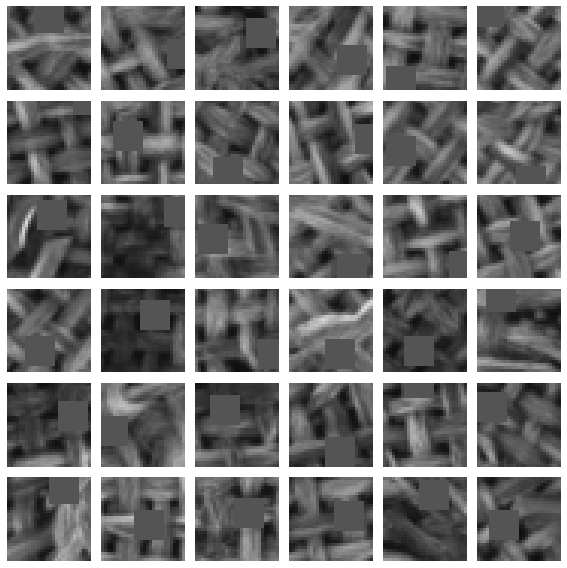

In [7]:
f,axs = plt.subplots(6,6,figsize=(8,8))
for ii,ax in enumerate(axs.ravel()):
    ax.imshow(train_img[ii], cmap="gray", vmin=0., vmax=1.)
    ax.set_axis_off()
f.tight_layout()

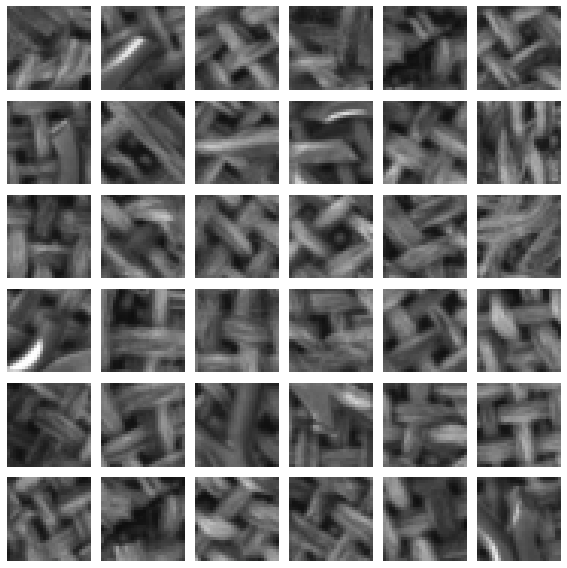

In [8]:
f,axs = plt.subplots(6,6,figsize=(8,8))
for ii,ax in enumerate(axs.ravel()):
    ax.imshow(cv_img[ii], cmap="gray", vmin=0., vmax=1.)
    ax.set_axis_off()
f.tight_layout()

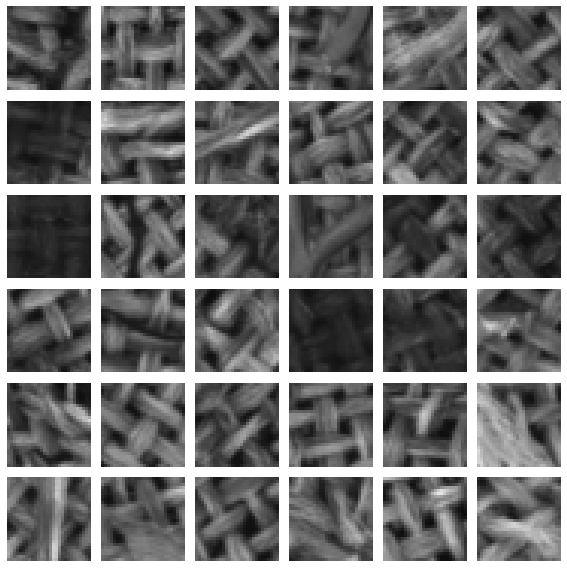

In [9]:
f,axs = plt.subplots(6,6,figsize=(8,8))
for ii,ax in enumerate(axs.ravel()):
    ax.imshow(test_img[ii], cmap="gray", vmin=0., vmax=1.)
    ax.set_axis_off()
f.tight_layout()

## Set-up the tuner
The HillClimbingTuner is a subclass of **nni.networkmorphism_tuner.networkmorphism_tuner.NetworkMorphismTuner** with some methods overloaded so that is runs the NASH algorithm. The tuner object is in charge of providing the models to be trained, retreiving the results after trining and saving the trained models on disk with their parameters.

In [10]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = MODEL_PATH,
    gen_size = GEN_SIZE)

## Training

In [11]:
model_nb = 0
gen_id = 0
n_iter = 0
timing = []
losses = []
accuracies = []
parameters = []
confusion_matrices = []

if os.path.isdir(tuner.path):
    filesToRemove = [os.path.join(tuner.path,f) for f in os.listdir(tuner.path)]
    
    if filesToRemove:
        answ = input("Directory %s exists, overwrite? (Y/n)"%tuner.path)
        while answ not in "Yn":
            answ = input("Directory %s exists, overwrite? (Y/n)"%tuner.path)
        if answ!="Y":
            raise RuntimeError("Directory exists!")

        for f in filesToRemove:
            os.remove(f)

Directory /home/btayart/MS-IA/FilRouge/nash_test/test_defects_nash_run3 exists, overwrite? (Y/n)Y


In [12]:
t00 = time.time()
t0 = t00
while gen_id <= MAX_GEN:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s - %ds elapsed"%(n_iter,parameter_id, t0-t00))
    
    graph = tuner.generate_parameters(parameter_id)
    model = graph.produce_torch_model().cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
    T = N_EPOCH_TRAIN * (2 if n_iter==0 else 1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T)
    
    
    try:
        training.train_net(model, train_loader, optimizer, n_epoch=T, verbose=1, lr_scheduler = scheduler)

        loss, accuracy, confusion = training.test_net(model, crossval_loader)
        loss_t, accuracy_t, confusion_t = training.test_net(model, test_loader)
    except KeyboardInterrupt:
        raise
    except: # got a bug once... throw the bad model and move on
        loss, loss_t = 9999., 9999.
        accuracy, accuracy_t = 0., 0.
        confusion = np.zeros((N_CLASS,N_CLASS),dtype=int)
        confusion_t = np.zeros((N_CLASS,N_CLASS),dtype=int)
        print("ERROR")
    model.cpu()
    model.set_weight_to_graph()
    tuner.receive_trial_result(parameter_id, loss, model)  
        
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
    
    n_iter += 1
    if tuner.training_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append([loss,loss_t])
    accuracies.append([accuracy,accuracy_t])
    confusion_matrices.append([confusion, confusion_t])
    
tt = t1-t00
h = (tt)//3600
m = (tt - 3600*h)//60
s = (tt - 3600*h - 60*m)//1
print("******** DONE ********")
print("Full NAS search done in %dh %dm %ds seconds"%(h,m,s))

accuracies = np.array(accuracies)
losses = np.array(losses)
timing = np.array(timing)
cm = np.array(confusion_matrices)
arr_path = os.path.join(tuner.path, "metrics.npz")
np.savez(arr_path, timing=timing,
        losses=losses, accuracies=accuracies, confusion_matrices=cm)


Iteration 0 - gen00_model0 - 0s elapsed
Training done, 20 epochs in 90.2s, loss at last epoch: 0.6585
Well classified  7257 /  9600, (75.59% accuracy)
Average loss : 0.596290
Well classified 36028 / 48000, (75.06% accuracy)
Average loss : 0.608691
Best model so far : gen00_model0 (0)

Iteration 1 - gen01_model0 - 92s elapsed
Training done, 10 epochs in 83.2s, loss at last epoch: 0.7507
Well classified  6824 /  9600, (71.08% accuracy)
Average loss : 0.692484
Well classified 33872 / 48000, (70.57% accuracy)
Average loss : 0.715371
Best model so far : gen00_model0 (0)

Iteration 2 - gen01_model1 - 180s elapsed
Training done, 10 epochs in 68.8s, loss at last epoch: 0.5980
Well classified  7444 /  9600, (77.54% accuracy)
Average loss : 0.543256
Well classified 36902 / 48000, (76.88% accuracy)
Average loss : 0.559814
Best model so far : gen01_model1 (2)

Iteration 3 - gen01_model2 - 252s elapsed
Training done, 10 epochs in 147.3s, loss at last epoch: 0.7210
Well classified  6913 /  9600, (7

Training done, 10 epochs in 842.1s, loss at last epoch: 0.0168
Well classified  9001 /  9600, (93.76% accuracy)
Average loss : 0.230279
Well classified 44986 / 48000, (93.72% accuracy)
Average loss : 0.227802
Best model so far : gen03_model1 (18)

Iteration 27 - gen04_model2 - 7480s elapsed
ERROR
Best model so far : gen03_model1 (18)

Iteration 28 - gen04_model3 - 7481s elapsed
Training done, 10 epochs in 600.1s, loss at last epoch: 0.0164
Well classified  9024 /  9600, (94.00% accuracy)
Average loss : 0.210364
Well classified 45211 / 48000, (94.19% accuracy)
Average loss : 0.215585
Best model so far : gen03_model1 (18)

Iteration 29 - gen04_model4 - 8114s elapsed
ERROR
Best model so far : gen03_model1 (18)

Iteration 30 - gen04_model5 - 8115s elapsed
Training done, 10 epochs in 862.3s, loss at last epoch: 0.0154
Well classified  9012 /  9600, (93.88% accuracy)
Average loss : 0.201962
Well classified 45284 / 48000, (94.34% accuracy)
Average loss : 0.190134
Best model so far : gen04_mod

## Display results
Now, display the training results, confusion matrix and final graph architecture. 

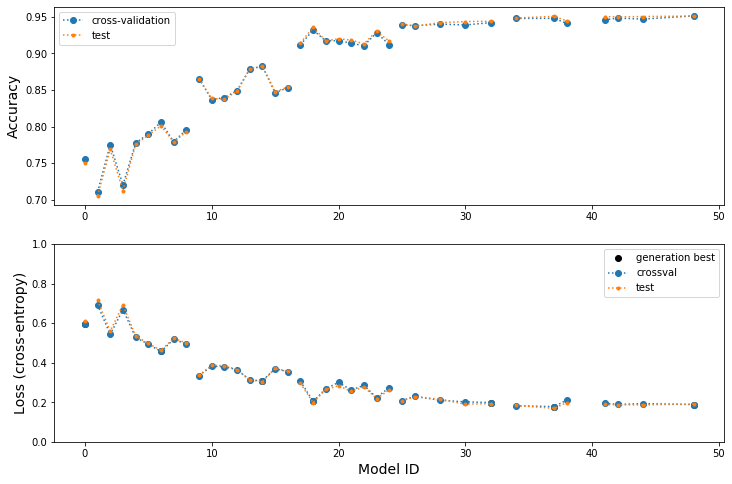

In [13]:
def insert_gap(vec, gen_size=GEN_SIZE):
    """
    Inser a nan in the vector between generations
    Remove bad values
    """
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    last_gen = gen[-1]

    ind = np.empty((n_models+last_gen,))
    ind[:] = np.nan
    val = np.empty((n_models+last_gen,))
    val[:] = np.nan

    ind[model_id+gen] = model_id
    val[model_id+gen] = vec
    
    valid  = np.logical_and(val!=9999, val!=0)
    ind = ind[valid]
    val = val[valid]
    
    return ind, val


def get_best_metric(vec, gen_size=GEN_SIZE):
    """Return id and metric of best model at each generation"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    n_gen = gen[-1]+1
    best_id, best_metric = np.zeros((n_gen)), np.zeros((n_gen))
    for ii in range(n_gen):
        imin = vec[gen == ii].argmin()
        shift = 0 if 0 == ii else 1+(ii-1)*gen_size
        best_id[ii] = imin+shift
        best_metric[ii] = vec[imin+shift]
    return best_id, best_metric


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(*insert_gap(accuracies[:, 0]), "o:", label="cross-validation")
plt.plot(*insert_gap(accuracies[:, 1]), ".:",label="test")
plt.legend()
plt.ylabel("Accuracy", fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(*get_best_metric(losses[:, 0]), "ok", label="generation best")
plt.plot(*insert_gap(losses[:, 0]), ".:",label="crossval")
plt.plot(*insert_gap(losses[:, 1]), ".:",label="test")
plt.ylabel("Loss (cross-entropy)", fontsize=14)
plt.xlabel("Model ID", fontsize=14)
plt.ylim(0.,1.)
plt.legend();

In [14]:
best_id = tuner.get_best_model_id()
print("The confusion matrix for the best model is:")
print(np.array2string(cm[best_id,1]))

The confusion matrix for the best model is:
[[7853   70  499  301   83   16]
 [  26 7889   31   11    7    2]
 [  68   29 6886  425   60    4]
 [  36   10  487 7217   37    3]
 [  13    2   95   46 7810    4]
 [   4    0    2    0    3 7971]]


parameters in best model: 13695380


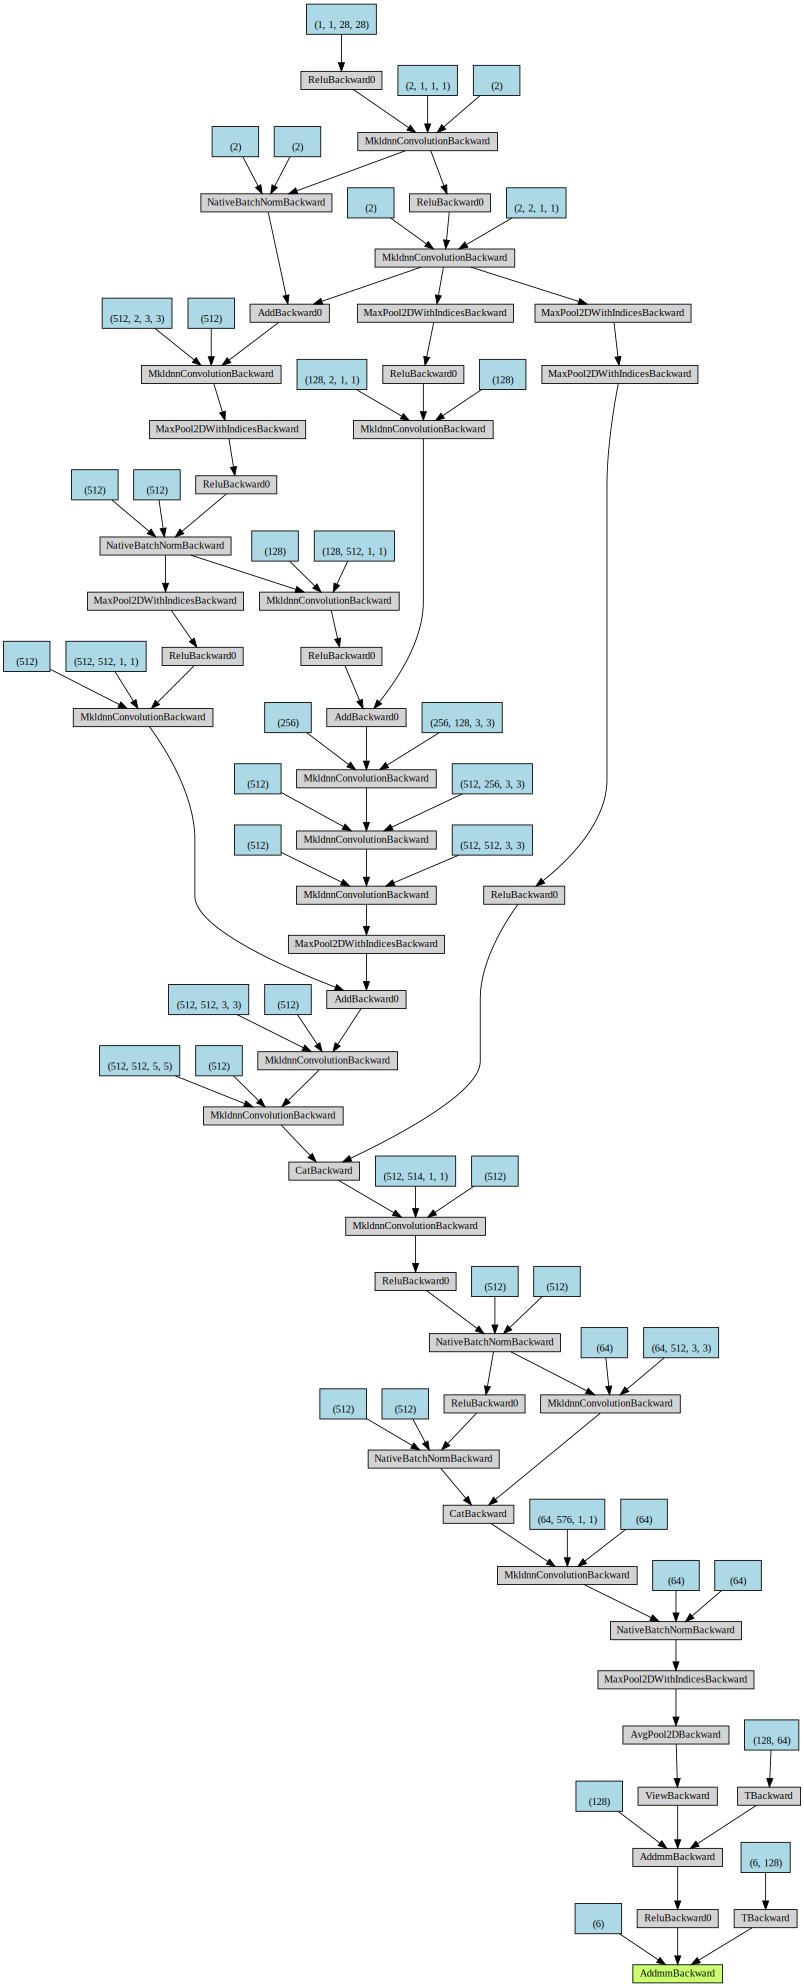

In [15]:
best_id = tuner.get_best_model_id()
best_graph = tuner.load_model_by_id(best_id, load_weights=True)
best_model = best_graph.produce_torch_model()
best_model.eval()

params = sum([p.numel() for p in best_model.parameters()])
print("parameters in best model:", params)

x,y = test_set[0]
x.unsqueeze_(0)
z = torch.zeros_like(x, requires_grad=True)

make_dot(best_model(z))

